In [1]:
# Plot style configuration (run this at the top of your notebook)
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook", font_scale=1.4)
sns.set_style("whitegrid")

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["axes.spines.top"] = True
plt.rcParams["axes.spines.right"] = True


In [2]:
import seaborn as sns
model_names = ["GRPO-Default", "GRPO-Epochs-2", "GRPO-Epochs-3", "GRPO-Unlikeliness-2", "DeepSeek-Prover-V1.5-SFT", "GRPO-Epochs-4", "GRPO-Unlikeliness-1", "GRPO-High-KL"]
palette = sns.color_palette("tab10", n_colors=len(model_names))
model_colors = {name: color for name, color in zip(model_names, palette)}

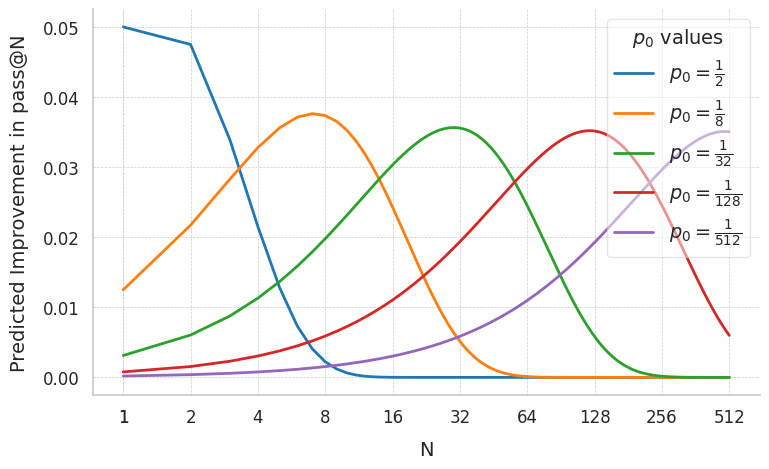

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Use seaborn paper style
# sns.set_context("paper", font_scale=1.5)
# sns.set_style("darkgrid")

# Parameters
epsilon = 0.1
# Ns = np.array([2**i for i in range(10)])  # N from 1 to 512 in powers of 2
# Ns = np.insert(Ns, 0, 1)  # Add 1 to the beginning
Ns = np.array(list(range(1, 513)))
Nticks = np.array([2**i for i in range(10)])
Nticks = np.insert(Nticks, 0, 1)
p0_list = [1 / (2 ** n) for n in [1, 3, 5, 7, 9]]  # 1/2, 1/8, 1/32, 1/128, 1/512

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
for p0 in p0_list:
    p_rl = (1 + epsilon) * p0
    passn_rl = 1 - (1 - p_rl) ** Ns
    passn_0 = 1 - (1 - p0) ** Ns
    improvement = passn_rl - passn_0
    label = rf"$p_0 = \frac{{1}}{{{int(1/p0)}}}$"
    ax.plot(Ns, improvement, label=label)

# Axes settings
ax.set_xscale("log", base=2)
ax.set_xticks(Nticks)
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_xlabel("N", labelpad=10)
ax.set_ylabel("Predicted Improvement in pass@N", labelpad=10)
# ax.set_title("Predicted Improvement in pass@N", pad=15)
# ax.legend(title="$p_0$ values", loc="lower right", frameon=True)
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.legend(title="$p_0$ values", loc="upper right", frameon=True, facecolor='white', framealpha=0.5, fontsize='small', title_fontsize='small')

sns.despine()

plt.tight_layout()
plt.savefig("final_figures/pass_n_improvement.pdf", format="pdf")
plt.show()


['PAPER_default_grpo - train/total_unique_proofs', 'PAPER_grpo_hikl_pe2 - train/total_unique_proofs', 'PAPER_grpo_hikl_pe3 - train/total_unique_proofs', 'PAPER_grpo_hikl_pe1_rr025 - train/total_unique_proofs', 'PAPER_grpo_pe2_rr025 - train/total_unique_proofs']


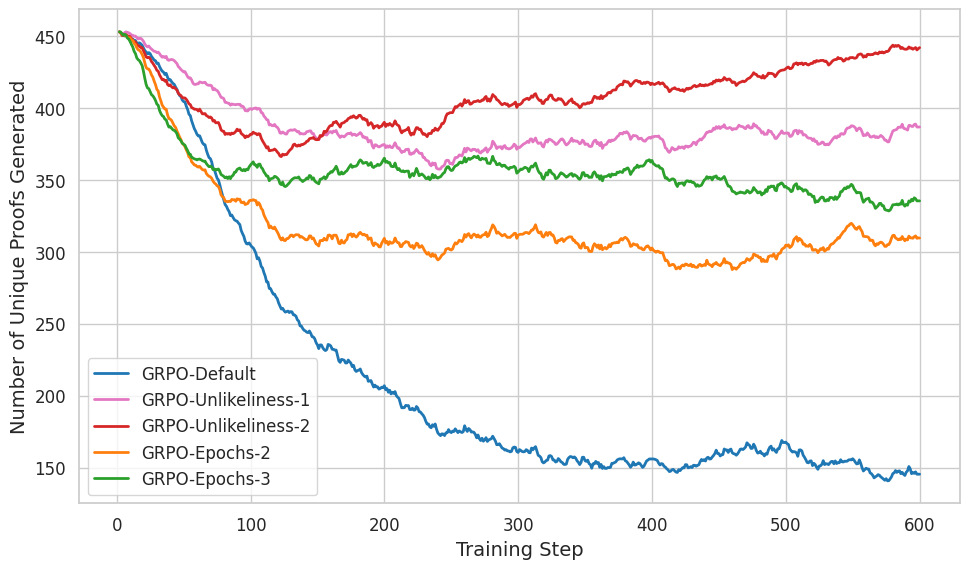

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# sns.set_context("paper", font_scale=1.5)
# sns.set_style("darkgrid")

# Load the CSV file
# file_path = "/home/awhe/projects/verl/notebooks/data/wandb_export_2025-05-14T15_04_18.399-04_00.csv"
file_path = "/home/awhe/projects/verl/notebooks/data/wandb_export_2025-05-19T20_24_02.207-04_00.csv"

df = pd.read_csv(file_path)

# Extract all columns that correspond to "train/total_unique_proofs"
proof_cols = [col for col in df.columns if "train/total_unique_proofs" in col and "__" not in col]


def time_weighted_ema_ignore_nans(x, y, alpha=0.3):
    """
    Compute a time-weighted EMA while ignoring NaNs in y.
    `x`: array of time steps
    `y`: array of values (may contain NaNs)
    `alpha`: smoothing factor
    """
    ema = []
    last_ema = None
    for i in range(len(y)):
        if np.isnan(y[i]):
            ema.append(last_ema)
        else:
            if last_ema is None:
                last_ema = y[i]
            else:
                delta_t = x[i] - x[i - 1]
                weight = 1 - np.exp(-alpha * delta_t)
                last_ema = weight * y[i] + (1 - weight) * last_ema
            ema.append(last_ema)
    return np.array(ema)

def time_weighted_ema(x, y, alpha=0.3):
    """
    Apply time-weighted exponential moving average to a series.
    `x` is the array of time steps.
    `y` is the array of values.
    `alpha` controls the smoothing (0 < alpha < 1).
    """
    ema = [y[0]]
    for i in range(1, len(y)):
        delta_t = x[i] - x[i - 1]
        weight = 1 - np.exp(-alpha * delta_t)
        ema_value = weight * y[i] + (1 - weight) * ema[-1]
        ema.append(ema_value)
    return np.array(ema)

df_filled = df.copy()

label_map = {
    "PAPER_grpo_hikl_pe1_rr025": "GRPO-Unlikeliness-1",
    "PAPER_grpo_pe2_rr025": "GRPO-Unlikeliness-2",
    "PAPER_grpo_hikl_pe3": "GRPO-Epochs-3",
    "PAPER_grpo_hikl_pe2": "GRPO-Epochs-2",
    "PAPER_default_grpo": "GRPO-Default",
    "PAPER_grpo_hikl_pe4": "GRPO-Epochs-4",
}

# Plotting smoothed delta curves with forward-filled values
plt.figure(figsize=(10, 6))
proof_cols_keys = list(proof_cols)
proof_cols_keys.sort(key=lambda x: label_map[x.split(" - ")[0]])
print(proof_cols_keys)

proof_cols_keys = [
    proof_cols_keys[0],
    proof_cols_keys[3],
    proof_cols_keys[4],
    proof_cols_keys[1],
    proof_cols_keys[2],
]
for col in proof_cols_keys:
    if "pe4" in col:
        continue
    x = df_filled["Step"][:600].to_numpy()
    y = df_filled[col][:600].to_numpy()
    y_deltas = y[1:] - y[:-1]
    x_deltas = x[1:]
    ema_method = time_weighted_ema_ignore_nans if not "pe4" in col else time_weighted_ema
    y_smoothed = ema_method(x_deltas, y_deltas, alpha=0.05)
    orig_label = col.split(" - ")[0]
    plt.plot(x_deltas, y_smoothed, label=label_map[orig_label], color=model_colors[label_map[orig_label]])

x_coord = 210
y_coord = 390
dx = -80
dy = 20


plt.xlabel("Training Step")
plt.ylabel("Number of Unique Proofs Generated")
# plt.title("Number of Unique Proofs Generated at Each Step (Smoothed EMA)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("final_figures/unique_proofs.pdf", format="pdf")
plt.show()




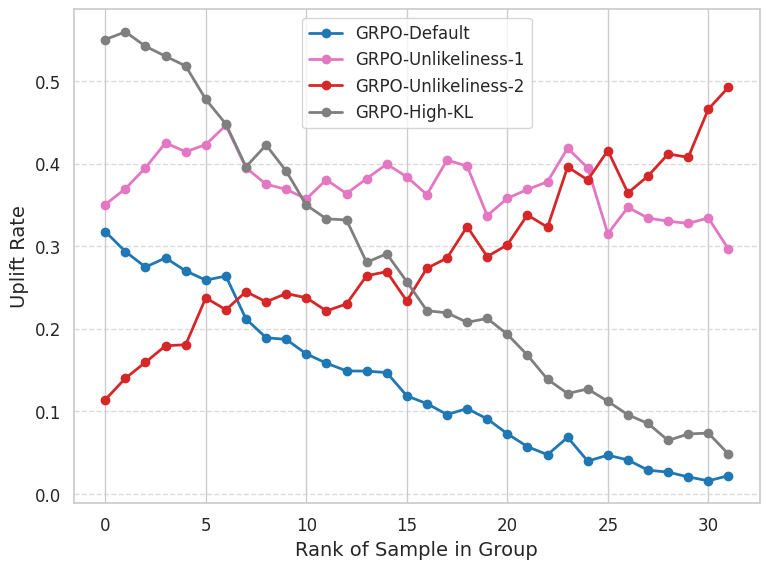

In [10]:
import matplotlib.pyplot as plt
import pickle as pkl
import numpy as np

def compute_uplift_rate(path1, path2, positives=True, incr=True):

    with open(path1, 'rb') as f1:
        probs1 = pkl.load(f1)

    with open(path2, 'rb') as f2:
        probs2 = pkl.load(f2)

    correct_mask = np.array([x['correct'] for x in probs1])
    logprobs = np.array([x['logprob'] for x in probs1])
    logprobs2 = np.array([x['logprob'] for x in probs2])

    logprobs_per_problem = logprobs.reshape(-1, 32)
    logprobs2_per_problem = logprobs2.reshape(-1, 32)
    correct_mask_per_problem = correct_mask.reshape(-1, 32)

    ranked_logprobs_per_problem = np.zeros_like(logprobs_per_problem)
    ranked_logprobs2_per_problem = np.zeros_like(logprobs2_per_problem)
    ranked_logprob_deltas = np.zeros_like(logprobs_per_problem)

    for k in range(len(logprobs_per_problem)):
        logprobs_k = logprobs_per_problem[k]
        logprobs2_k = logprobs2_per_problem[k]
        sorted_indices = np.argsort(logprobs_k)[::-1]
        ranked_logprobs_per_problem[k] = logprobs_k[sorted_indices]
        ranked_logprobs2_per_problem[k] = logprobs2_k[sorted_indices]

        if incr:
            ranked_logprob_deltas[k] = ranked_logprobs2_per_problem[k] > ranked_logprobs_per_problem[k]
        else:
            ranked_logprob_deltas[k] = ranked_logprobs2_per_problem[k] < ranked_logprobs_per_problem[k]
        correct_mask_k = correct_mask_per_problem[k][sorted_indices]

        if positives is not None:
            if positives:
                ranked_logprob_deltas[k][~correct_mask_k] = np.nan
            else:
                ranked_logprob_deltas[k][correct_mask_k] = np.nan

    ranks = np.arange(ranked_logprob_deltas.shape[1])
    avg_per_rank = np.nanmean(ranked_logprob_deltas, axis=0)
    ranks = np.arange(ranked_logprob_deltas.shape[1])
    return ranks, avg_per_rank


probs_files = {
    "GRPO-Default": (
        "/home/awhe/projects/verl/notebooks/logprobs_final/default_grpo_initial.pkl",
        "/home/awhe/projects/verl/notebooks/logprobs_final/default_grpo_trained.pkl"
    ),
    # "GRPO-Epochs-2": (
    #     "/home/awhe/projects/verl/notebooks/logprobs_final/grpo_hikl_pe2_initial.pkl",
    #     "/home/awhe/projects/verl/notebooks/logprobs_final/grpo_hikl_pe2_trained.pkl"
    # ),
    # "GRPO-Epochs-3": (
    #     "/home/awhe/projects/verl/notebooks/logprobs_final/grpo_hikl_pe3_initial.pkl",
    #     "/home/awhe/projects/verl/notebooks/logprobs_final/grpo_hikl_pe3_trained.pkl"
    # ),
    "GRPO-Unlikeliness-1": (
        "/home/awhe/projects/verl/notebooks/logprobs_final/grpo_pe1_rr025_initial.pkl",
        "/home/awhe/projects/verl/notebooks/logprobs_final/grpo_pe1_rr025_trained.pkl"
    ),
    "GRPO-Unlikeliness-2": (
        "/home/awhe/projects/verl/notebooks/logprobs_final/grpo_pe2_rr025_initial.pkl",
        "/home/awhe/projects/verl/notebooks/logprobs_final/grpo_pe2_rr025_trained.pkl"
    ),
    "GRPO-High-KL": (
        "/home/awhe/projects/verl/notebooks/logprobs_final/kl_only_initial.pkl",
        "/home/awhe/projects/verl/notebooks/logprobs_final/kl_only_trained.pkl"
    )
}

plt.figure(figsize=(8, 6))

for key, (path1, path2) in probs_files.items():
    ranks, avg_per_rank = compute_uplift_rate(path1, path2)
    plt.plot(ranks, avg_per_rank, marker='o', linestyle='-', linewidth=2, label=key, color=model_colors[key])

# plt.plot(ranks, avg_per_rank2, marker='o', linestyle='-', linewidth=2, label='grpo_full_pe1')
# plt.plot(ranks, avg_per_rank3, marker='o', linestyle='-', linewidth=2, label='GRPO')
plt.xlabel('Rank of Sample in Group')
plt.ylabel('Uplift Rate')
# plt.title('Rate of Positive Sample\'s Prob Increase by Rank')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig("final_figures/uplift_rate.pdf", format="pdf")
plt.show()





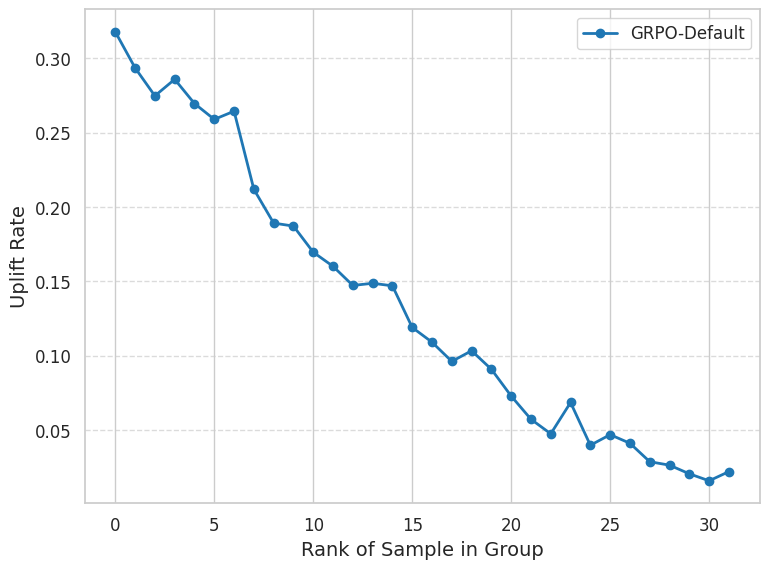

In [8]:
plt.figure(figsize=(8, 6))

key = "GRPO-Default"
path1 = "/home/awhe/projects/verl/notebooks/logprobs_final/default_grpo_initial.pkl"
path2 = "/home/awhe/projects/verl/notebooks/logprobs_final/default_grpo_trained.pkl"
ranks, avg_per_rank = compute_uplift_rate(path1, path2)
plt.plot(ranks, avg_per_rank, marker='o', linestyle='-', linewidth=2, label=key, color=model_colors[key])

# plt.plot(ranks, avg_per_rank2, marker='o', linestyle='-', linewidth=2, label='grpo_full_pe1')
# plt.plot(ranks, avg_per_rank3, marker='o', linestyle='-', linewidth=2, label='GRPO')
plt.xlabel('Rank of Sample in Group')
plt.ylabel('Uplift Rate')
# plt.title('Rate of Positive Sample\'s Prob Increase by Rank')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig("final_figures/uplift_rate_default.pdf", format="pdf")
plt.show()

In [8]:
import sys
import pandas as pd
import numpy as np
sys.path.append('/home/awhe/projects/verl')
sys.path.append('/home/awhe/projects/verl/examples/inference/')

from verl.lean.utils import *
# from compute_metrics import load_proofs_and_compute_metrics
import os
import glob
import jsonlines
from collections import defaultdict

def load_proofs(proofs_path):
    proofs = []
    file_pattern = os.path.join(proofs_path, f"proofs_device*.jsonl")
    # filter out batch files, which would double-count proofs
    file_pattern = [f for f in glob.glob(file_pattern) if "batch" not in f]
    for file in file_pattern:
        with jsonlines.open(file, mode='r') as reader:
            for item in reader:
                proofs.append(item)
    return proofs

def compute_pass_metrics_v2(dataset, proofs, num_samples, prefix: str = "train"):
    theorem_full_names = list(dataset["theorem_full_name"].unique())
    problem_attempts = defaultdict(list)

    for proof in proofs:
        theorem_full_name = proof["theorem_name"]
        success = proof["correct"] if "correct" in proof else False
        # TODO this should be handled by the verifier
        if uses_sorry(proof["proof"]):
            success = False
        problem_attempts[theorem_full_name].append(int(success))

    num_insufficient_attempts = 0
    num_excessive_attempts = 0
    for theorem_full_name in theorem_full_names:
        if len(problem_attempts[theorem_full_name]) < num_samples:
            num_insufficient_attempts += 1
            # print(f"Warning: {theorem_full_name} has fewer attempts than num_samples: {problem_attempts[theorem_full_name]}")
        if len(problem_attempts[theorem_full_name]) > num_samples:
            num_excessive_attempts += 1
            # print(f"Warning: {theorem_full_name} has more attempts than num_samples: {problem_attempts[theorem_full_name]}")

    if num_insufficient_attempts > 0:
        print(f"Warning: {num_insufficient_attempts} theorems have fewer attempts than num_samples: {num_samples}")
    if num_excessive_attempts > 0:
        print(f"Warning: {num_excessive_attempts} theorems have more attempts than num_samples: {num_samples}")

    pass_at_n = {}
    n = 1
    while n <= num_samples:
        if n not in pass_at_n:
            # we take average per trial
            num_trials = num_samples // n
            pass_at_n[n] = [0 for _ in range(num_trials)]
        for theorem_full_name in theorem_full_names:
            if theorem_full_name not in problem_attempts:
                continue
            if len(problem_attempts[theorem_full_name]) < n:
                continue

            attempts = problem_attempts[theorem_full_name]
            passes = []
            assert len(attempts) % n == 0
            for i in range(0, len(attempts), n):
                group = attempts[i:i+n]
                group_pass = int(sum(group) > 0)
                passes.append(group_pass)
                trial = i // n
                pass_at_n[n][trial] += group_pass
        n *= 2

    pass_at_n_means = {n: np.mean([p / len(theorem_full_names) for p in pass_at_n[n]]) for n in pass_at_n}

    def compute_std(arr):
        if len(arr) == 1:
            return 0
        return np.std(arr, ddof=1)

    pass_at_n_stds = {n: compute_std([p / len(theorem_full_names) for p in pass_at_n[n]]) for n in pass_at_n}

    # pass_at_n = {n: pass_at_n[n] / len(theorem_full_names) for n in pass_at_n}

    final_metrics = {
        f"{prefix}/pass_at_{n}": pass_at_n_means[n] for n in pass_at_n_means
    }
    final_metrics.update({
        f"{prefix}/pass_at_{n}_std": pass_at_n_stds[n] for n in pass_at_n_stds
    })

    return final_metrics

dataset_path = "/home/awhe/projects/verl/data/mff-lwb-unseen-200.parquet"
base_path = "/data/user_data/awhe/model-evals/"
num_samples = 512

legend = {
    "DeepSeek-Prover-V1.5-SFT": "base_us_200x512",
    "GRPO-Default": "grpo_default_us_200x512",
    "GRPO-Unlikeliness-1": "grpo_pe_1_rr025_us_200x512_fixed",
    "GRPO-Unlikeliness-2": "grpo_pe2_rr025_us_200x512",
    # "GRPO-Epochs-2": "grpo_pe2_us_200x512",
    # "GRPO-Epochs-3": "grpo_pe3_us_200x512",
    "GRPO-High-KL": "kl_only_us_200x512"
}

metrics = {}

dataset = pd.read_parquet(dataset_path)

for name, legend_name in legend.items():
    print(name)
    metrics[name] = compute_pass_metrics_v2(dataset, load_proofs(base_path + legend_name), num_samples)

print(metrics)

n_range = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]

DeepSeek-Prover-V1.5-SFT
GRPO-Default
GRPO-Unlikeliness-1
GRPO-Unlikeliness-2
GRPO-High-KL
{'DeepSeek-Prover-V1.5-SFT': {'train/pass_at_1': 0.524794921875, 'train/pass_at_2': 0.62646484375, 'train/pass_at_4': 0.6829296874999999, 'train/pass_at_8': 0.720546875, 'train/pass_at_16': 0.754375, 'train/pass_at_32': 0.7834375, 'train/pass_at_64': 0.811875, 'train/pass_at_128': 0.83125, 'train/pass_at_256': 0.8474999999999999, 'train/pass_at_512': 0.86, 'train/pass_at_1_std': 0.023572906717444598, 'train/pass_at_2_std': 0.016630433193720023, 'train/pass_at_4_std': 0.013783011107053657, 'train/pass_at_8_std': 0.01380468023637533, 'train/pass_at_16_std': 0.010606601717798222, 'train/pass_at_32_std': 0.009437293044088446, 'train/pass_at_64_std': 0.005938674695827062, 'train/pass_at_128_std': 0.0025000000000000022, 'train/pass_at_256_std': 0.010606601717798222, 'train/pass_at_512_std': 0}, 'GRPO-Default': {'train/pass_at_1': 0.70974609375, 'train/pass_at_2': 0.74294921875, 'train/pass_at_4': 0.761

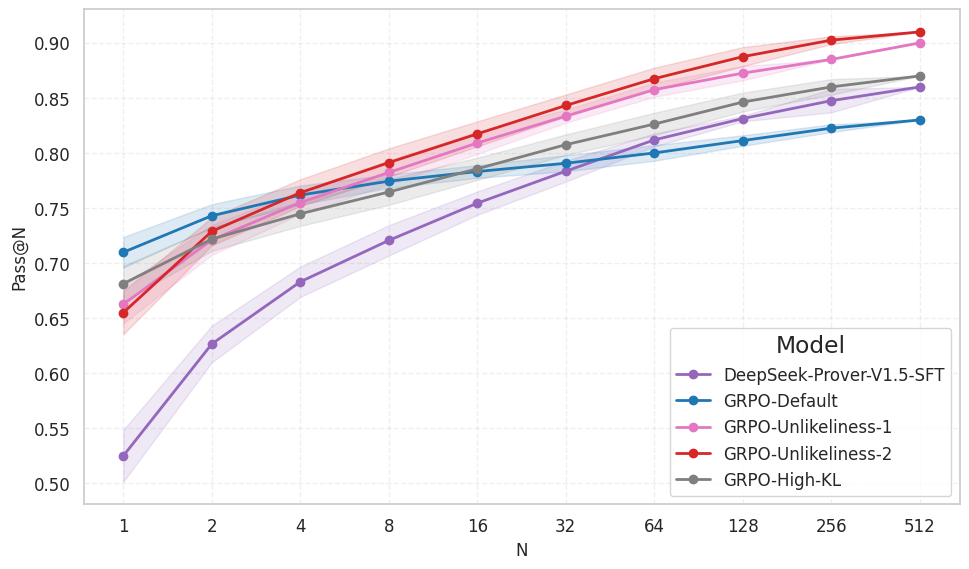

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pass_rates_with_std(metrics, n_range, title=""):
    plt.figure(figsize=(10, 6))
    for name, metric in metrics.items():
        pass_rates = np.array([metric[f"train/pass_at_{n}"] for n in n_range])
        stds = np.array([metric[f"train/pass_at_{n}_std"] for n in n_range])
        plt.plot(n_range, pass_rates, label=name, linewidth=2, marker='o', color=model_colors[name])
        plt.fill_between(n_range, pass_rates - stds, pass_rates + stds, alpha=0.15, color=model_colors[name])

    plt.xscale('log', base=2)
    plt.grid(True, which="both", ls="--", alpha=0.3)
    plt.xlabel('N', fontsize=12)
    plt.ylabel('Pass@N', fontsize=12)
    # plt.title(f'Pass@N ({title})', fontsize=14)
    plt.legend(title='Model')
    plt.xticks(n_range, labels=[str(n) for n in n_range])
    plt.tight_layout()
    if title != "":
        plt.savefig(f"final_figures/pass_rates_{title}.pdf", format="pdf")
    plt.show()


plot_pass_rates_with_std(metrics, n_range, "D_val_with_std")

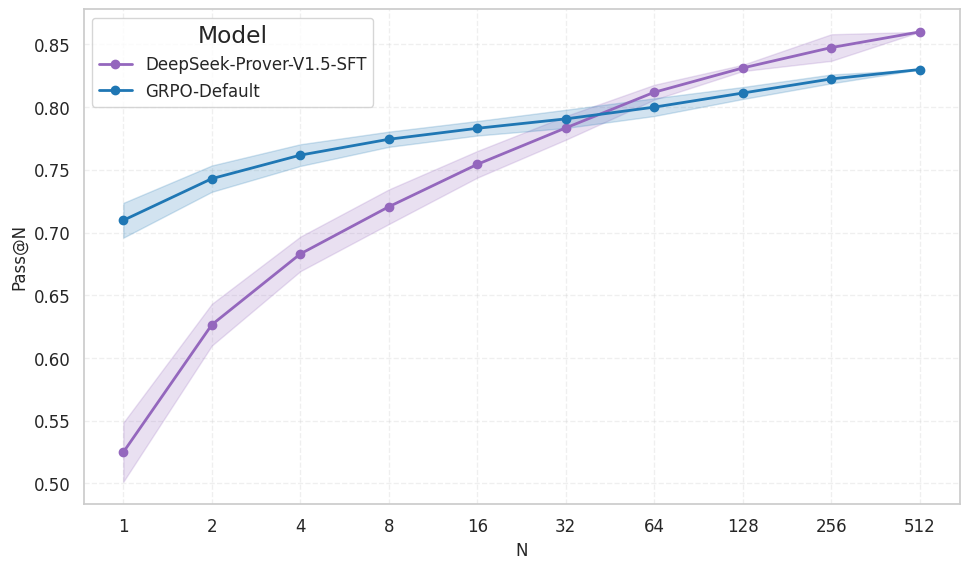

In [22]:
subset = {
    "DeepSeek-Prover-V1.5-SFT": metrics["DeepSeek-Prover-V1.5-SFT"],
    "GRPO-Default": metrics["GRPO-Default"],
}
plot_pass_rates_with_std(subset, n_range, "D_val_default_with_std")